Epoch 1/5, Train Loss: 0.4288, Train Acc: 0.1748, Val Loss: 0.4231, Val Acc: 0.1942
Epoch 2/5, Train Loss: 0.4250, Train Acc: 0.1804, Val Loss: 0.4233, Val Acc: 0.1942
Epoch 3/5, Train Loss: 0.4246, Train Acc: 0.1746, Val Loss: 0.4229, Val Acc: 0.1914
Epoch 4/5, Train Loss: 0.4244, Train Acc: 0.1710, Val Loss: 0.4241, Val Acc: 0.1942
Epoch 5/5, Train Loss: 0.4248, Train Acc: 0.1879, Val Loss: 0.4236, Val Acc: 0.1942

LSTM - F1 Score (Micro): 0.3744

Classification Report for LSTM:

                 precision    recall  f1-score   support

          Drama       0.54      1.00      0.70      3625
         Comedy       0.00      0.00      0.00      2316
         Action       0.00      0.00      0.00      1144
       Thriller       0.00      0.00      0.00      1318
      Adventure       0.00      0.00      0.00       581
        Romance       0.00      0.00      0.00      1226
          Crime       0.00      0.00      0.00       723
Science Fiction       0.00      0.00      0.00       484

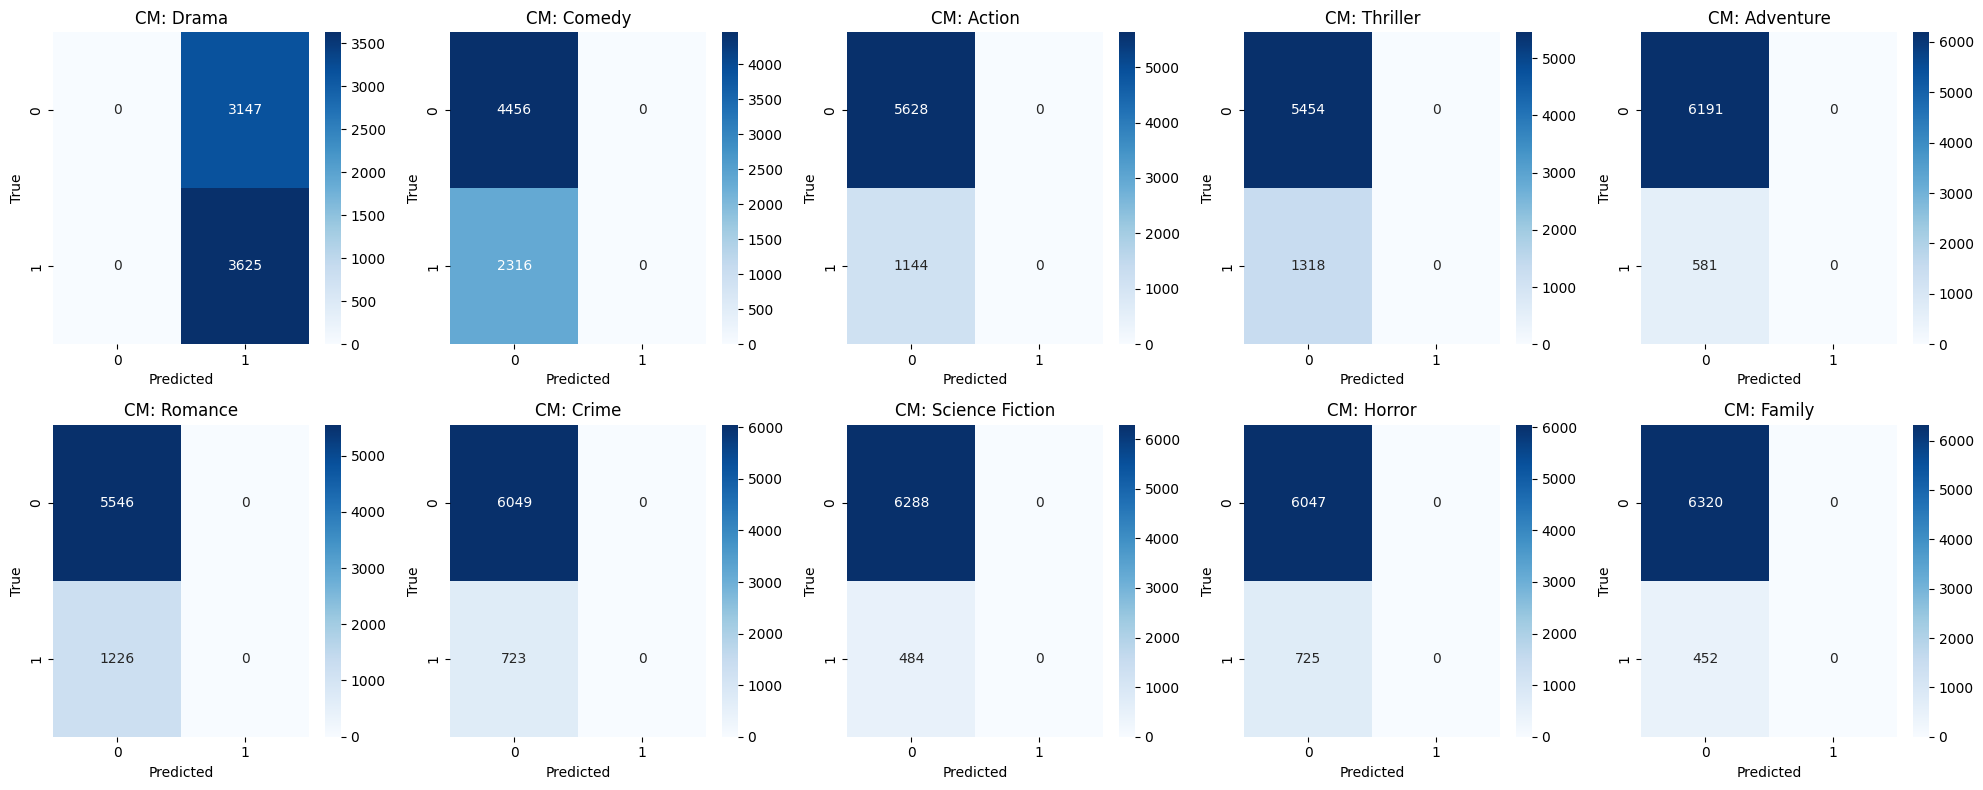

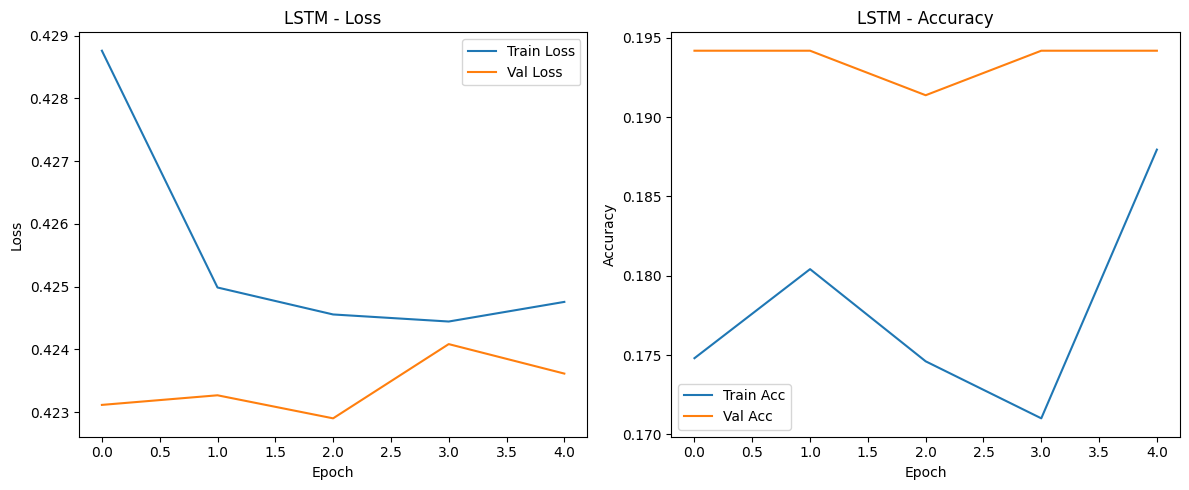

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Train Loss: 0.3262, Train Acc: 0.2177, Val Loss: 0.2848, Val Acc: 0.2921
Epoch 2/3, Train Loss: 0.2526, Train Acc: 0.3371, Val Loss: 0.2830, Val Acc: 0.3153
Epoch 3/3, Train Loss: 0.2031, Train Acc: 0.4281, Val Loss: 0.2998, Val Acc: 0.3235

BERT - F1 Score (Micro): 0.6272

Classification Report for BERT:

                 precision    recall  f1-score   support

          Drama       0.76      0.79      0.77      3625
         Comedy       0.82      0.49      0.61      2316
         Action       0.72      0.45      0.56      1144
       Thriller       0.66      0.42      0.52      1318
      Adventure       0.67      0.31      0.42       581
        Romance       0.65      0.35      0.46      1226
          Crime       0.68      0.25      0.37       723
Science Fiction       0.74      0.65      0.69       484
         Horror       0.76      0.68      0.72       725
         Family       0.80      0.35      0.49       452

      micro avg       0.74      0.54      0.63     1

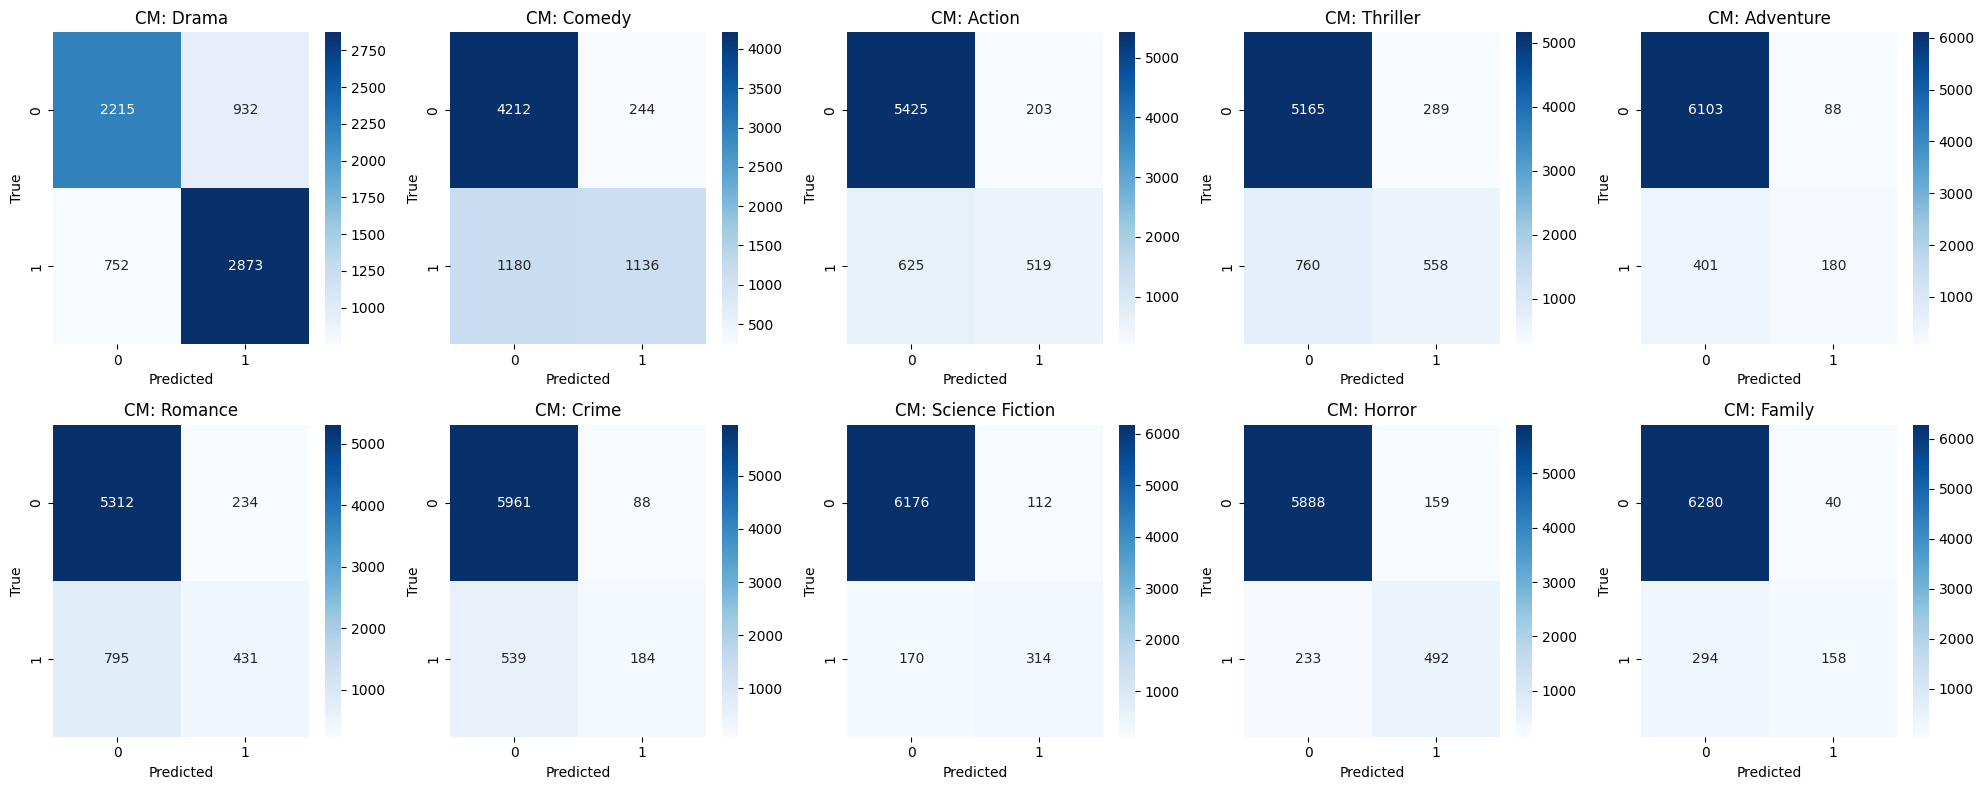

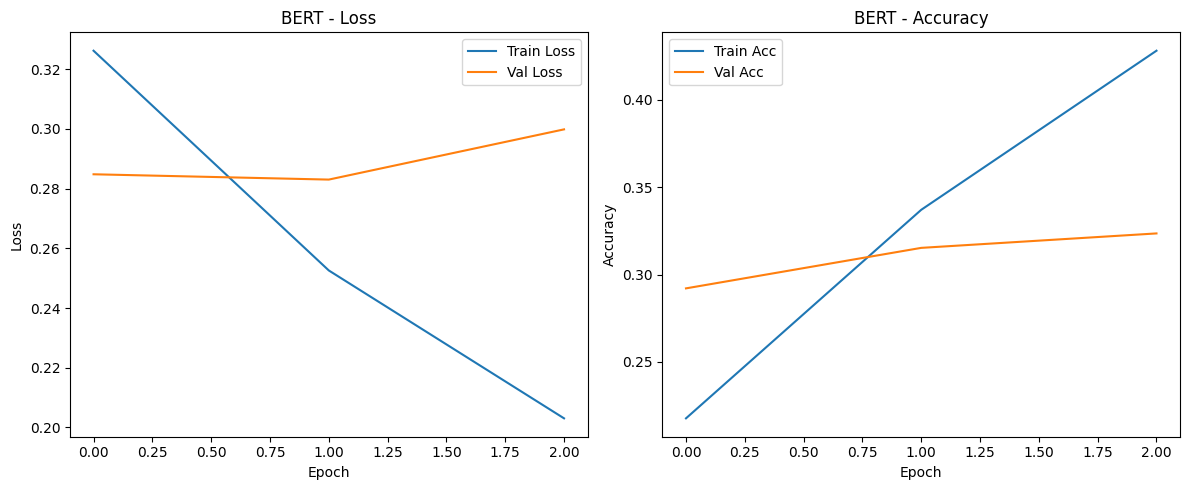

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Train Loss: 0.3716, Train Acc: 0.1592, Val Loss: 0.3053, Val Acc: 0.2615
Epoch 2/3, Train Loss: 0.2947, Train Acc: 0.2628, Val Loss: 0.2949, Val Acc: 0.2817
Epoch 3/3, Train Loss: 0.2714, Train Acc: 0.3001, Val Loss: 0.2932, Val Acc: 0.2880

GPT - F1 Score (Micro): 0.5687

Classification Report for GPT:

                 precision    recall  f1-score   support

          Drama       0.77      0.75      0.76      3625
         Comedy       0.87      0.35      0.50      2316
         Action       0.80      0.29      0.43      1144
       Thriller       0.68      0.32      0.44      1318
      Adventure       0.73      0.13      0.22       581
        Romance       0.66      0.20      0.30      1226
          Crime       0.62      0.36      0.45       723
Science Fiction       0.85      0.49      0.62       484
         Horror       0.78      0.64      0.70       725
         Family       0.78      0.28      0.41       452

      micro avg       0.77      0.45      0.57     125

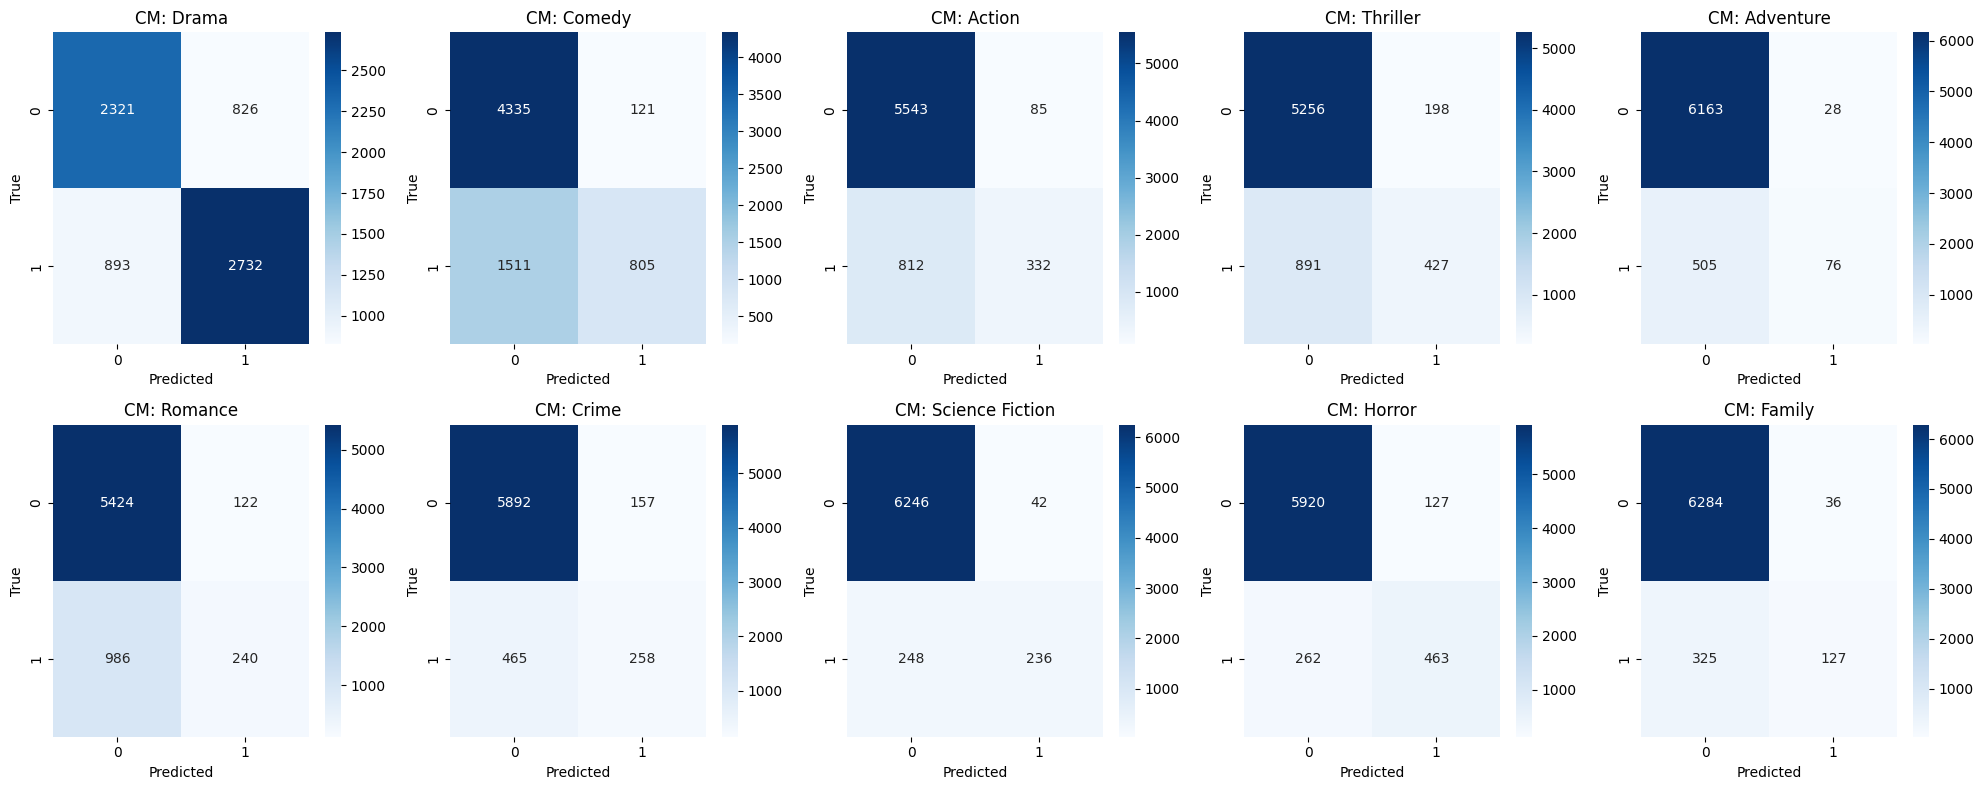

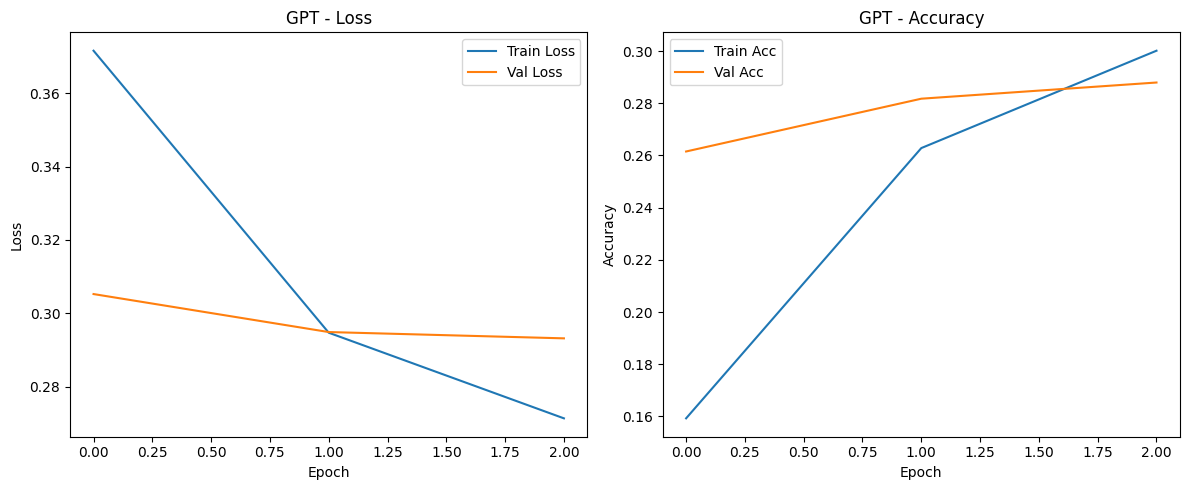

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, GPT2Tokenizer, GPT2ForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load and Preprocess the Dataset
df = pd.read_csv('filtered_movies.csv', delimiter='|')

# Handle missing values in the Genre column
df['Genre'] = df['Genre'].fillna('')  # Replace NaN with empty string

# Clean the Genre column (split multi-label genres)
df['Genre'] = df['Genre'].apply(lambda x: [g.strip() for g in x.split(',')] if x else [])

# Select top genres based on the histogram
top_genres = ['Drama', 'Comedy', 'Action', 'Thriller', 'Adventure', 'Romance', 'Crime', 'Science Fiction', 'Horror', 'Family']

# Filter movies with at least one of the top genres
df['Genre'] = df['Genre'].apply(lambda x: [g for g in x if g in top_genres])
df = df[df['Genre'].map(len) > 0]  # Remove rows with no matching genres

# Multi-label encoding
mlb = MultiLabelBinarizer(classes=top_genres)
y = mlb.fit_transform(df['Genre'])

# Text data
X = df['Overview'].fillna('').values  # Also handle missing values in Overview

# Train-Test-Validation Split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Step 2: Custom Dataset for PyTorch
class MovieDataset(Dataset):
    def __init__(self, texts, labels, tokenizer=None, max_len=128, is_bert_or_gpt=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_bert_or_gpt = is_bert_or_gpt

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        if self.is_bert_or_gpt:
            # For BERT or GPT
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.FloatTensor(label)
            }
        else:
            # For LSTM (we'll tokenize later in the model)
            return {
                'text': text,
                'labels': torch.FloatTensor(label)
            }

# Step 3: Define Models

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask=None):
        embedded = self.dropout(self.embedding(input_ids))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        dense_out = self.fc(hidden[-1])
        return self.sigmoid(dense_out)

# Step 4: Training and Evaluation Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, is_bert_or_gpt=False):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_preds, train_labels = [], []

        for batch in train_loader:
            optimizer.zero_grad()
            if is_bert_or_gpt:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask).logits
            else:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            preds = (outputs > 0.5).float()
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss = total_train_loss / len(train_loader)
        train_acc = accuracy_score(np.array(train_labels), np.array(train_preds))
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        total_val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                if is_bert_or_gpt:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    outputs = model(input_ids, attention_mask=attention_mask).logits
                else:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['labels'].to(device)
                    outputs = model(input_ids)

                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = total_val_loss / len(val_loader)
        val_acc = accuracy_score(np.array(val_labels), np.array(val_preds))
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Convert lists to NumPy arrays before returning
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)

    return train_losses, val_losses, train_accuracies, val_accuracies, val_preds, val_labels

# Step 5: Evaluation and Visualization
def evaluate_and_visualize(model_name, val_preds, val_labels, train_losses, val_losses, train_accuracies, val_accuracies):
    # F1 Score and Classification Report
    f1 = f1_score(val_labels, val_preds, average='micro')
    print(f"\n{model_name} - F1 Score (Micro): {f1:.4f}")
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(val_labels, val_preds, target_names=top_genres))

    # Confusion Matrix (for each genre)
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()
    for i, genre in enumerate(top_genres):
        cm = confusion_matrix(val_labels[:, i], val_preds[:, i])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(f'CM: {genre}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    plt.tight_layout()
    plt.show()

    # Training and Validation Loss/Accuracy Plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Step 6: Run for Each Model

# 6.1: LSTM Model
# Tokenization for LSTM
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Using BERT tokenizer for simplicity
def tokenize_for_lstm(texts, tokenizer, max_len=128):
    input_ids = []
    for text in texts:
        encoding = tokenizer(text, max_length=max_len, padding='max_length', truncation=True, return_tensors='pt')
        input_ids.append(encoding['input_ids'].flatten())
    return torch.stack(input_ids)

# Prepare data for LSTM
train_input_ids = tokenize_for_lstm(X_train, tokenizer).to(device)
val_input_ids = tokenize_for_lstm(X_val, tokenizer).to(device)
test_input_ids = tokenize_for_lstm(X_test, tokenizer).to(device)

class LSTMDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'labels': torch.FloatTensor(self.labels[idx])
        }

train_dataset_lstm = LSTMDataset(train_input_ids, y_train)
val_dataset_lstm = LSTMDataset(val_input_ids, y_val)
test_dataset_lstm = LSTMDataset(test_input_ids, y_test)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=32, shuffle=True)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=32)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=32)

# Initialize LSTM Model
vocab_size = tokenizer.vocab_size
embedding_dim = 128
hidden_dim = 256
output_dim = len(top_genres)
n_layers = 2
dropout = 0.5

lstm_model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train LSTM
train_losses_lstm, val_losses_lstm, train_accuracies_lstm, val_accuracies_lstm, val_preds_lstm, val_labels_lstm = train_model(
    lstm_model, train_loader_lstm, val_loader_lstm, criterion, optimizer, num_epochs=5, device=device
)

# Evaluate LSTM
evaluate_and_visualize("LSTM", val_preds_lstm, val_labels_lstm, train_losses_lstm, val_losses_lstm, train_accuracies_lstm, val_accuracies_lstm)

# 6.2: BERT Model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset_bert = MovieDataset(X_train, y_train, bert_tokenizer, is_bert_or_gpt=True)
val_dataset_bert = MovieDataset(X_val, y_val, bert_tokenizer, is_bert_or_gpt=True)
test_dataset_bert = MovieDataset(X_test, y_test, bert_tokenizer, is_bert_or_gpt=True)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=16)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=16)

# Initialize BERT Model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(top_genres)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(bert_model.parameters(), lr=2e-5)

# Train BERT
train_losses_bert, val_losses_bert, train_accuracies_bert, val_accuracies_bert, val_preds_bert, val_labels_bert = train_model(
    bert_model, train_loader_bert, val_loader_bert, criterion, optimizer, num_epochs=3, device=device, is_bert_or_gpt=True
)

# Evaluate BERT
evaluate_and_visualize("BERT", val_preds_bert, val_labels_bert, train_losses_bert, val_losses_bert, train_accuracies_bert, val_accuracies_bert)

# 6.3: GPT Model
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token  # GPT-2 doesn't have a pad token by default
train_dataset_gpt = MovieDataset(X_train, y_train, gpt_tokenizer, is_bert_or_gpt=True)
val_dataset_gpt = MovieDataset(X_val, y_val, gpt_tokenizer, is_bert_or_gpt=True)
test_dataset_gpt = MovieDataset(X_test, y_test, gpt_tokenizer, is_bert_or_gpt=True)

train_loader_gpt = DataLoader(train_dataset_gpt, batch_size=16, shuffle=True)
val_loader_gpt = DataLoader(val_dataset_gpt, batch_size=16)
test_loader_gpt = DataLoader(test_dataset_gpt, batch_size=16)

# Initialize GPT Model
gpt_model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=len(top_genres)).to(device)
gpt_model.config.pad_token_id = gpt_tokenizer.pad_token_id
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(gpt_model.parameters(), lr=2e-5)

# Train GPT
train_losses_gpt, val_losses_gpt, train_accuracies_gpt, val_accuracies_gpt, val_preds_gpt, val_labels_gpt = train_model(
    gpt_model, train_loader_gpt, val_loader_gpt, criterion, optimizer, num_epochs=3, device=device, is_bert_or_gpt=True
)

# Evaluate GPT
evaluate_and_visualize("GPT", val_preds_gpt, val_labels_gpt, train_losses_gpt, val_losses_gpt, train_accuracies_gpt, val_accuracies_gpt)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Train Loss: 0.4932, Train Acc: 0.0436, Val Loss: 0.4561, Val Acc: 0.1336
Epoch 2/5, Train Loss: 0.4391, Train Acc: 0.1373, Val Loss: 0.4239, Val Acc: 0.1757
Epoch 3/5, Train Loss: 0.4287, Train Acc: 0.1698, Val Loss: 0.4155, Val Acc: 0.1939
Epoch 4/5, Train Loss: 0.4241, Train Acc: 0.1733, Val Loss: 0.4219, Val Acc: 0.2088
Early stopping at epoch 4

BERT - Validation F1 Score (Micro): 0.4081

Classification Report for BERT (Validation):

                 precision    recall  f1-score   support

          Drama       0.71      0.78      0.74      3625
         Comedy       0.86      0.14      0.25      2316
         Action       0.81      0.07      0.13      1144
       Thriller       0.62      0.20      0.31      1318
      Adventure       0.00      0.00      0.00       581
        Romance       1.00      0.00      0.00      1226
          Crime       0.57      0.08      0.14       723
Science Fiction       0.93      0.03      0.05       484
         Horror       0.83      0

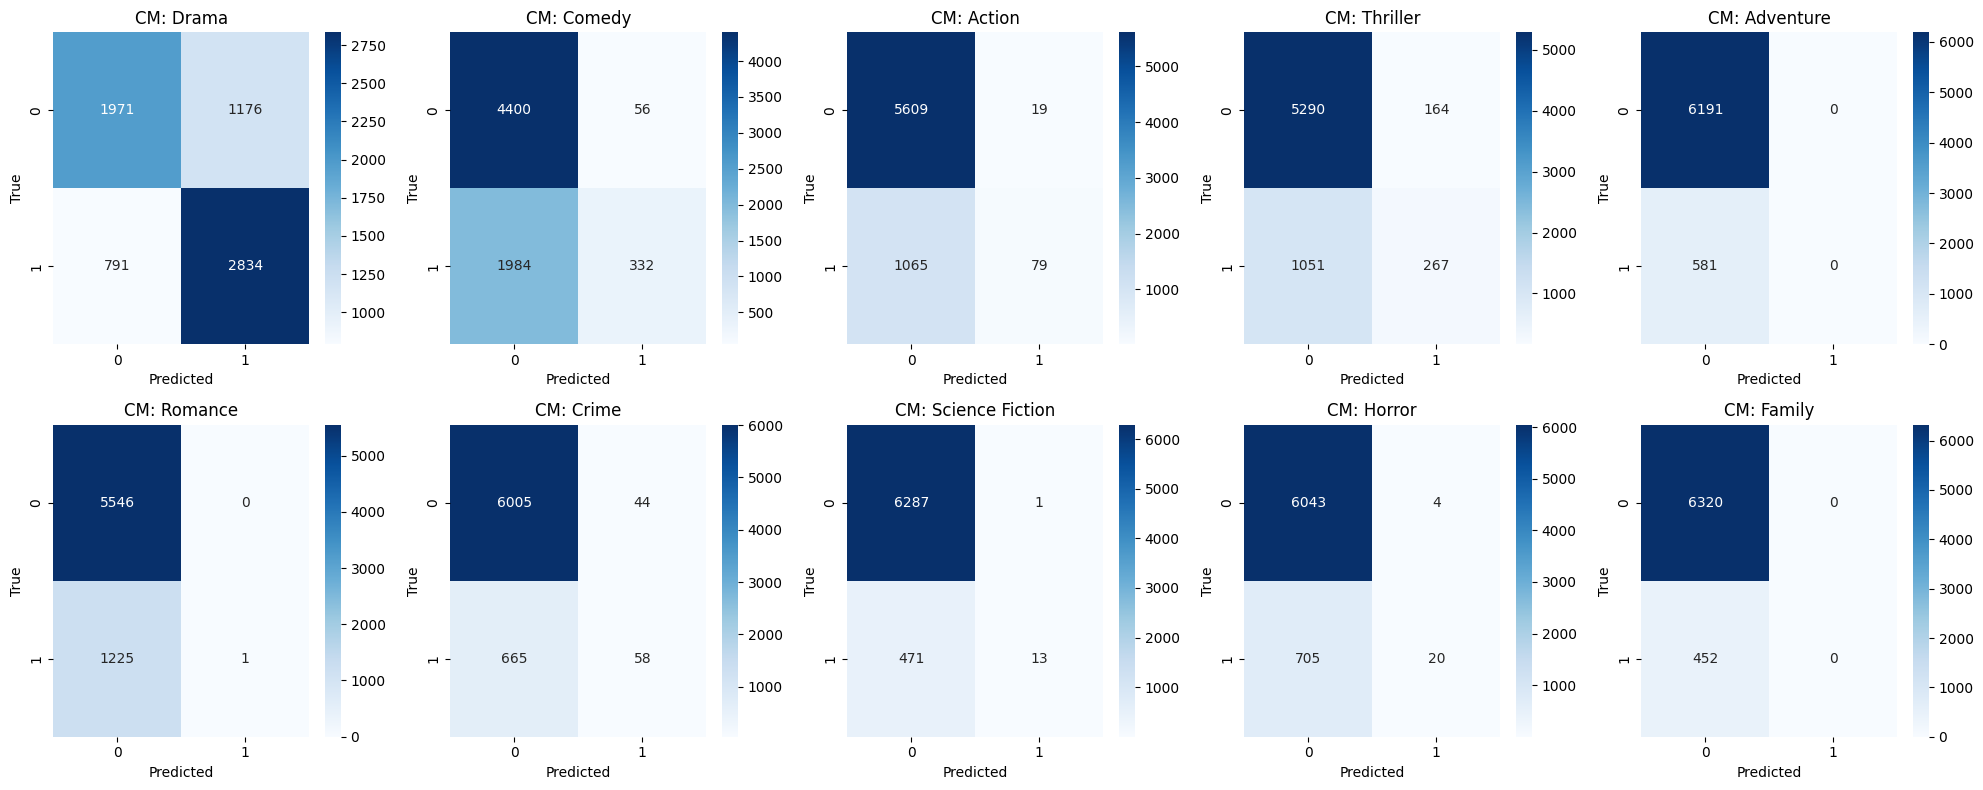

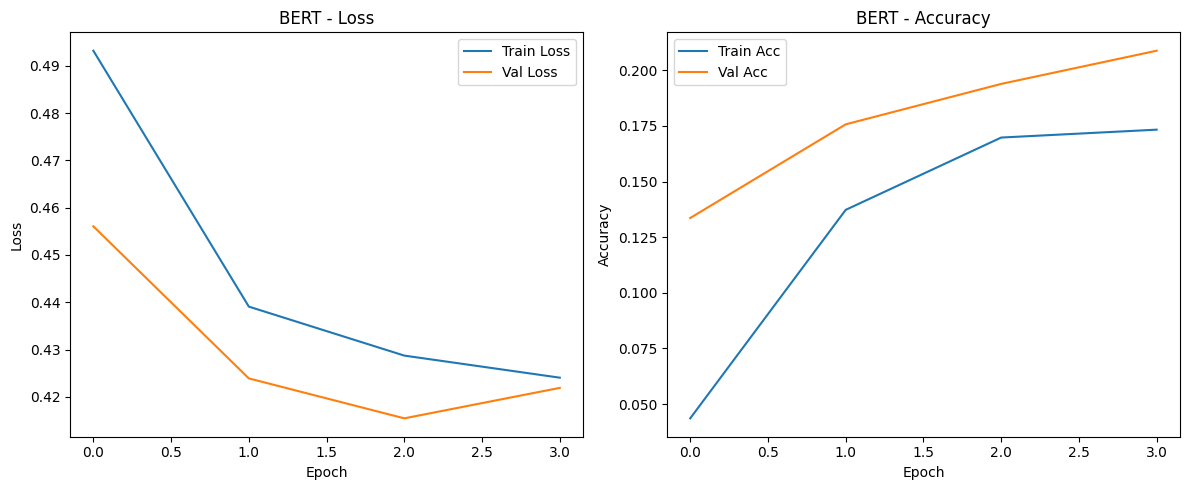

Test Loss: 0.4211, Test Accuracy: 0.2013, Test F1 Score (Micro): 0.4113

Classification Report for Test Set:

                 precision    recall  f1-score   support

          Drama       0.71      0.78      0.74      3695
         Comedy       0.89      0.14      0.24      2315
         Action       0.85      0.07      0.13      1063
       Thriller       0.59      0.21      0.31      1341
      Adventure       0.00      0.00      0.00       560
        Romance       1.00      0.00      0.01      1257
          Crime       0.69      0.09      0.16       779
Science Fiction       0.86      0.04      0.08       477
         Horror       0.59      0.01      0.03       763
         Family       0.00      0.00      0.00       469

      micro avg       0.72      0.29      0.41     12719
      macro avg       0.62      0.13      0.17     12719
   weighted avg       0.71      0.29      0.32     12719
    samples avg       0.53      0.35      0.40     12719


BERT (Test) - Validation F1 Sco

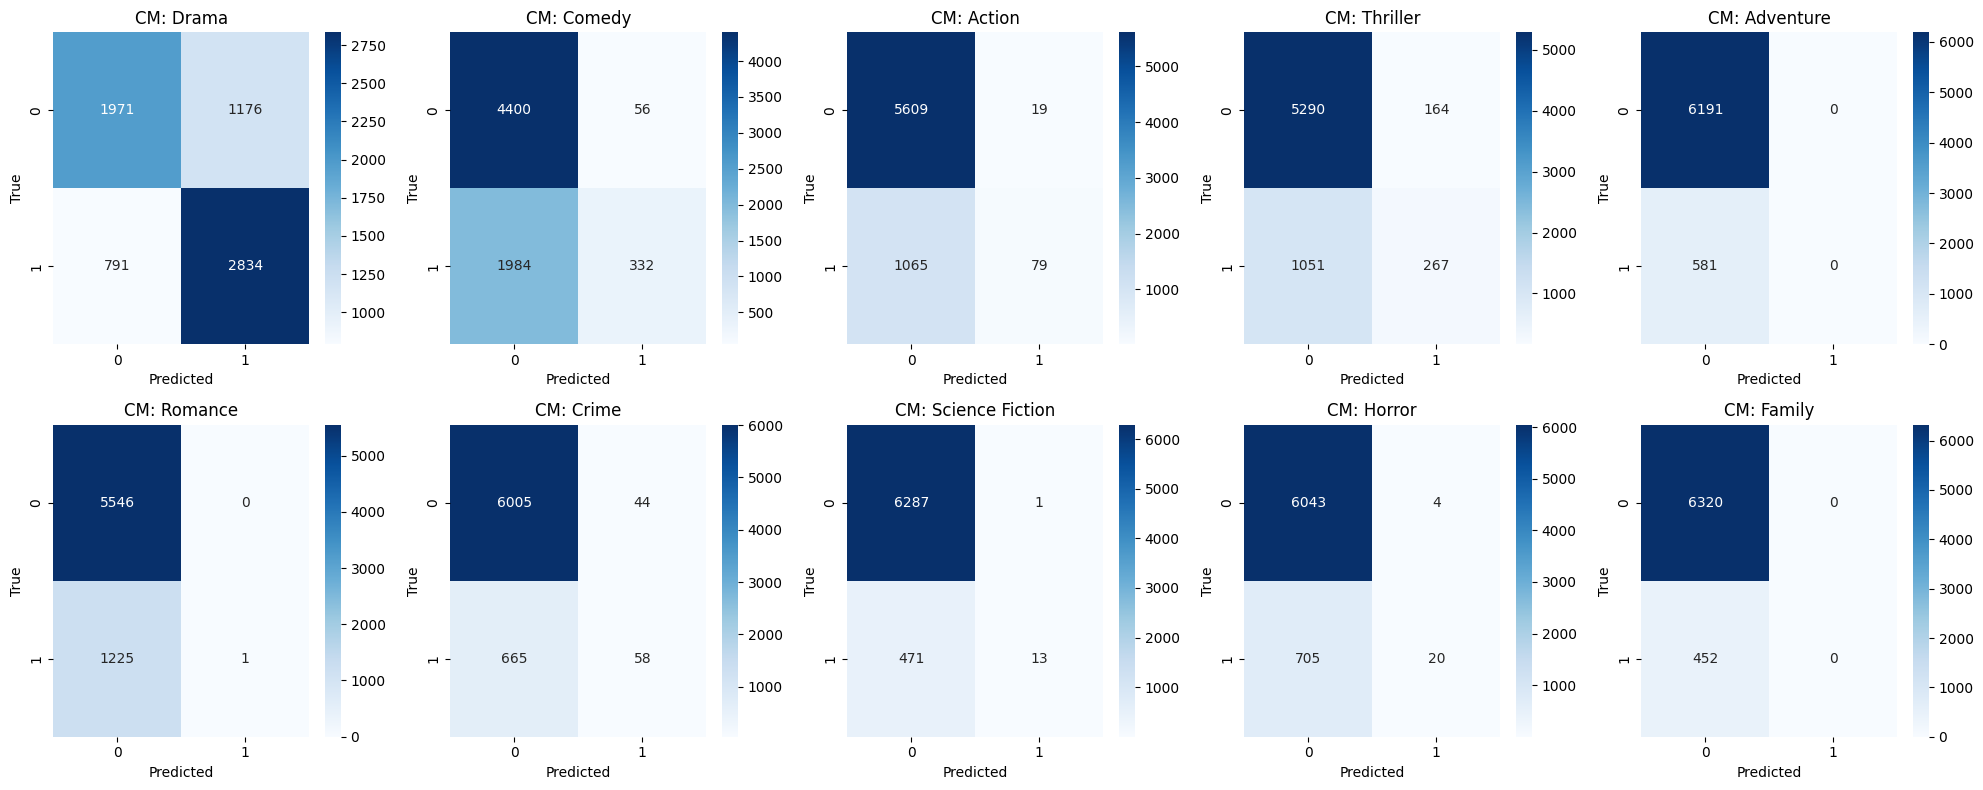

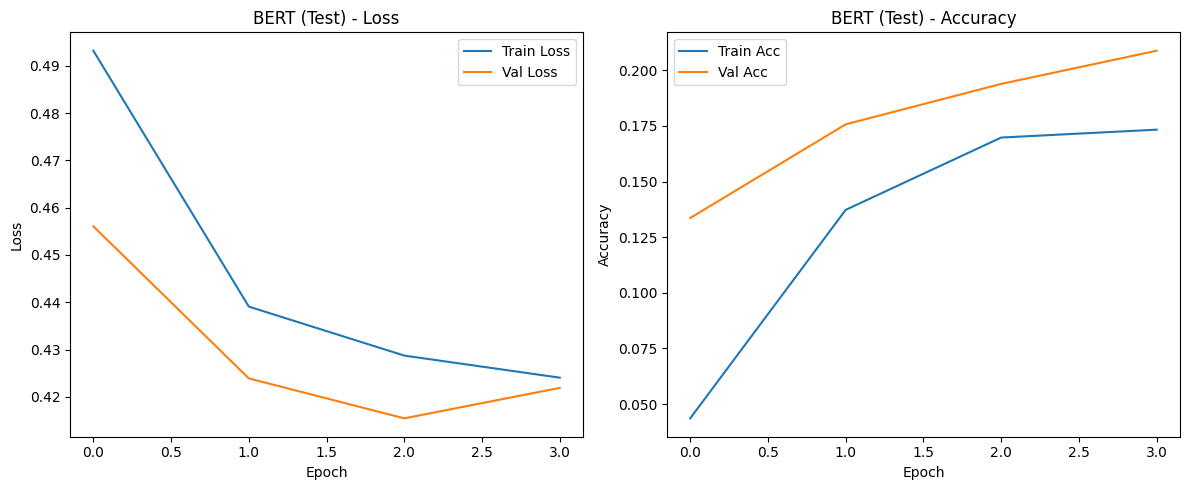


BERT (Test) - Test F1 Score (Micro): 0.4113

Classification Report for BERT (Test) (Test):

                 precision    recall  f1-score   support

          Drama       0.71      0.78      0.74      3695
         Comedy       0.89      0.14      0.24      2315
         Action       0.85      0.07      0.13      1063
       Thriller       0.59      0.21      0.31      1341
      Adventure       0.00      0.00      0.00       560
        Romance       1.00      0.00      0.01      1257
          Crime       0.69      0.09      0.16       779
Science Fiction       0.86      0.04      0.08       477
         Horror       0.59      0.01      0.03       763
         Family       0.00      0.00      0.00       469

      micro avg       0.72      0.29      0.41     12719
      macro avg       0.62      0.13      0.17     12719
   weighted avg       0.71      0.29      0.32     12719
    samples avg       0.53      0.35      0.40     12719



TypeError: list indices must be integers or slices, not tuple

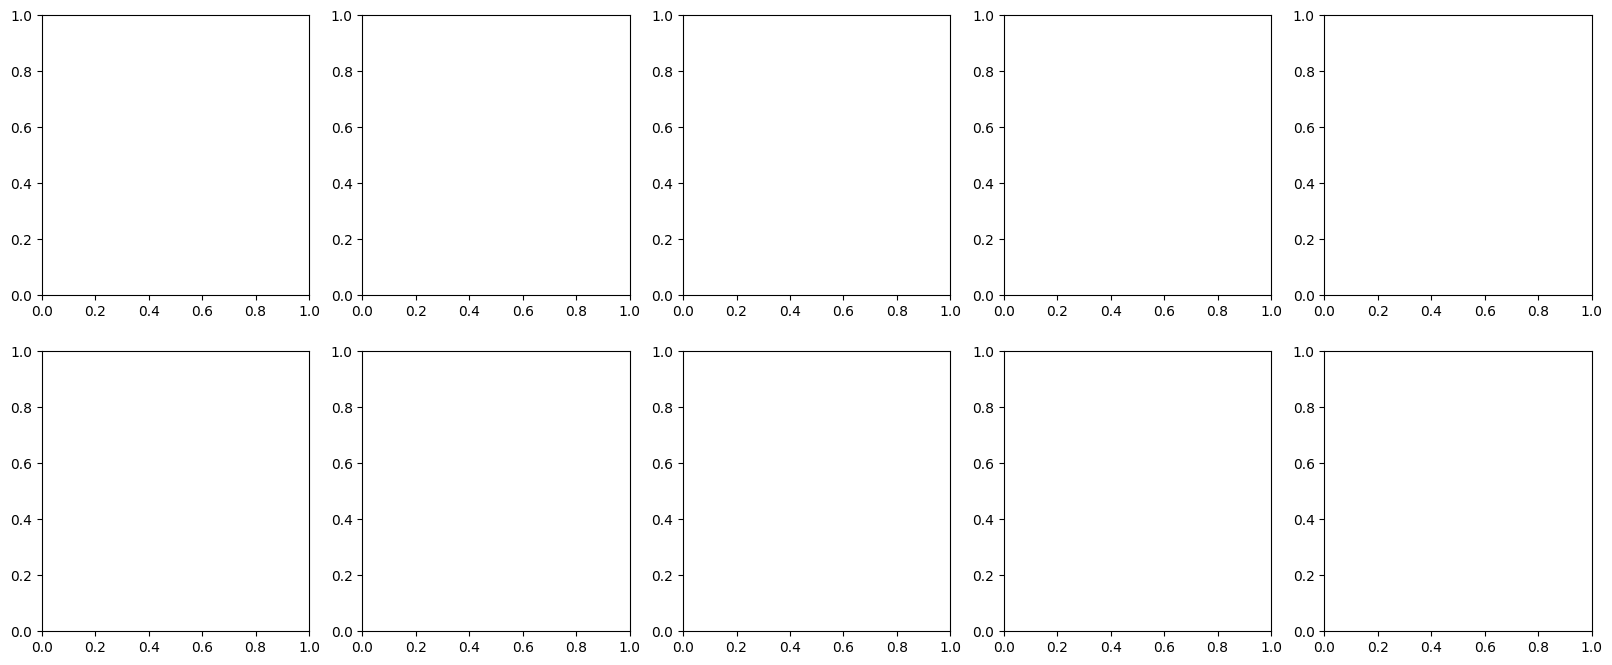

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load and Preprocess the Dataset
df = pd.read_csv('filtered_movies.csv', delimiter='|')

# Handle missing values in the Genre column
df['Genre'] = df['Genre'].fillna('')  # Replace NaN with empty string

# Clean the Genre column (split multi-label genres)
df['Genre'] = df['Genre'].apply(lambda x: [g.strip() for g in x.split(',')] if x else [])

# Select top genres based on the histogram
top_genres = ['Drama', 'Comedy', 'Action', 'Thriller', 'Adventure', 'Romance', 'Crime', 'Science Fiction', 'Horror', 'Family']

# Filter movies with at least one of the top genres
df['Genre'] = df['Genre'].apply(lambda x: [g for g in x if g in top_genres])
df = df[df['Genre'].map(len) > 0]  # Remove rows with no matching genres

# Multi-label encoding
mlb = MultiLabelBinarizer(classes=top_genres)
y = mlb.fit_transform(df['Genre'])

# Text data
X = df['Overview'].fillna('').values  # Also handle missing values in Overview

# Train-Test-Validation Split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Step 2: Custom Dataset for PyTorch
class MovieDataset(Dataset):
    def __init__(self, texts, labels, tokenizer=None, max_len=128, is_bert_or_gpt=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_bert_or_gpt = is_bert_or_gpt

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        if self.is_bert_or_gpt:
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.FloatTensor(label)
            }
        else:
            return {
                'text': text,
                'labels': torch.FloatTensor(label)
            }

# Step 3: Custom Loss Function with Label Smoothing
class LabelSmoothingBCEWithLogitsLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        target = target * (1.0 - self.smoothing) + 0.5 * self.smoothing
        return nn.BCEWithLogitsLoss()(pred, target)

# Step 4: Training Function with Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, is_bert_or_gpt=False, patience=1):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_preds, train_labels = [], []

        for batch in train_loader:
            optimizer.zero_grad()
            if is_bert_or_gpt:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask).logits
            else:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            preds = (outputs > 0.5).float()
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss = total_train_loss / len(train_loader)
        train_acc = accuracy_score(np.array(train_labels), np.array(train_preds))
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        total_val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                if is_bert_or_gpt:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    outputs = model(input_ids, attention_mask=attention_mask).logits
                else:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['labels'].to(device)
                    outputs = model(input_ids)

                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = total_val_loss / len(val_loader)
        val_acc = accuracy_score(np.array(val_labels), np.array(val_preds))
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_bert_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    return model, train_losses, val_losses, train_accuracies, val_accuracies, val_preds, val_labels

# Step 5: Test Evaluation Function
def evaluate_test_set(model, test_loader, criterion, device, is_bert_or_gpt=False):
    model.eval()
    total_test_loss = 0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            if is_bert_or_gpt:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask).logits
            else:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)

            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            preds = (outputs > 0.5).float()
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_loss = total_test_loss / len(test_loader)
    test_acc = accuracy_score(np.array(test_labels), np.array(test_preds))
    test_f1 = f1_score(np.array(test_labels), np.array(test_preds), average='micro')

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test F1 Score (Micro): {test_f1:.4f}")
    print(f"\nClassification Report for Test Set:\n")
    print(classification_report(np.array(test_labels), np.array(test_preds), target_names=top_genres))

    return test_preds, test_labels

# Step 6: Evaluation and Visualization
def evaluate_and_visualize(model_name, val_preds, val_labels, train_losses, val_losses, train_accuracies, val_accuracies, test_preds=None, test_labels=None):
    # F1 Score and Classification Report for Validation
    f1 = f1_score(val_labels, val_preds, average='micro')
    print(f"\n{model_name} - Validation F1 Score (Micro): {f1:.4f}")
    print(f"\nClassification Report for {model_name} (Validation):\n")
    print(classification_report(val_labels, val_preds, target_names=top_genres))

    # Confusion Matrix (for each genre) - Validation
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()
    for i, genre in enumerate(top_genres):
        cm = confusion_matrix(val_labels[:, i], val_preds[:, i])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(f'CM: {genre}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    plt.tight_layout()
    plt.show()

    # Training and Validation Loss/Accuracy Plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # If test set results are provided, visualize them
    if test_preds is not None and test_labels is not None:
        # F1 Score and Classification Report for Test
        test_f1 = f1_score(test_labels, test_preds, average='micro')
        print(f"\n{model_name} - Test F1 Score (Micro): {test_f1:.4f}")
        print(f"\nClassification Report for {model_name} (Test):\n")
        print(classification_report(test_labels, test_preds, target_names=top_genres))

        # Confusion Matrix (for each genre) - Test
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.ravel()
        for i, genre in enumerate(top_genres):
            cm = confusion_matrix(test_labels[:, i], test_preds[:, i])
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
            axes[i].set_title(f'CM: {genre}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')
        plt.tight_layout()
        plt.show()

# Step 7: BERT Model with Anti-Overfitting Techniques
# Data Preparation for BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset_bert = MovieDataset(X_train, y_train, bert_tokenizer, is_bert_or_gpt=True)
val_dataset_bert = MovieDataset(X_val, y_val, bert_tokenizer, is_bert_or_gpt=True)
test_dataset_bert = MovieDataset(X_test, y_test, bert_tokenizer, is_bert_or_gpt=True)

# Option 1: Increase batch size to 32 (uncomment to try)
train_loader_bert = DataLoader(train_dataset_bert, batch_size=32, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=32)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=32)

# Option 2: Keep original batch size of 16 (uncomment to try)
# train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)
# val_loader_bert = DataLoader(val_dataset_bert, batch_size=16)
# test_loader_bert = DataLoader(test_dataset_bert, batch_size=16)

# Initialize BERT Model with Increased Dropout
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=len(top_genres), hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config).to(device)

# Option 3: Freeze lower layers to reduce model complexity (uncomment to try)
# for name, param in bert_model.named_parameters():
#     if 'classifier' not in name and 'encoder.layer.10' not in name and 'encoder.layer.11' not in name:
#         param.requires_grad = False

# Loss Function with Label Smoothing
criterion = LabelSmoothingBCEWithLogitsLoss(smoothing=0.1)

# Optimizer with Weight Decay and Reduced Learning Rate
optimizer = optim.Adam(bert_model.parameters(), lr=1e-5, weight_decay=0.01)

# Option 4: Use original learning rate without weight decay (uncomment to try)
# optimizer = optim.Adam(bert_model.parameters(), lr=2e-5)

# Train BERT with Early Stopping
bert_model, train_losses_bert, val_losses_bert, train_accuracies_bert, val_accuracies_bert, val_preds_bert, val_labels_bert = train_model(
    bert_model, train_loader_bert, val_loader_bert, criterion, optimizer, num_epochs=5, device=device, is_bert_or_gpt=True, patience=1
)

# Evaluate on Validation Set
evaluate_and_visualize("BERT", val_preds_bert, val_labels_bert, train_losses_bert, val_losses_bert, train_accuracies_bert, val_accuracies_bert)

# Evaluate on Test Set
test_preds_bert, test_labels_bert = evaluate_test_set(bert_model, test_loader_bert, criterion, device, is_bert_or_gpt=True)

# Visualize Test Set Results
evaluate_and_visualize("BERT (Test)", val_preds_bert, val_labels_bert, train_losses_bert, val_losses_bert, train_accuracies_bert, val_accuracies_bert, test_preds_bert, test_labels_bert)